In [1]:
import numpy as np
import jax.numpy as jnp
from pathlib import Path
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# figure aesthetics
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])  # for dark themes
# plt.style.use(['seaborn-notebook'])

In [3]:
# custom libraries
import sys, os

sys.path.append(os.path.abspath('../../spaths'))
import spaths

sys.path.append(os.path.abspath('..'))
from utils import dmaps, mpl_utils

## Uncoupled hidden process

In [113]:
Ds = 1
Df = 3
eps = .001

D = Ds + Df
def drif_lin(t, x, dx):
    y, z = x[:Ds], x[Ds:]
    
    dx[:Ds] = 1.0
    dx[Ds:] = -z / eps

def disp_lin(t, x, dx):
    dx[:Ds] = 1.0
    dx[Ds:] = 1.0 / np.sqrt(eps)

sde_lin = spaths.ItoSDE(drif_lin, disp_lin)

In [129]:
# seed setting and solver
seed = 9735
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [130]:
# simulation params
dt = eps / 10
x0 = [1.0]*Ds + [0.0]*Df
tspan = (0.0, 0.5)

In [131]:
ens0 = np.array([x0])
sol_lin = em.solve(sde_lin, ens0, tspan, dt)
sol_lin.x.shape

(5002, 1, 4)

In [132]:
time = sol_lin.t
path = sol_lin.p[0]

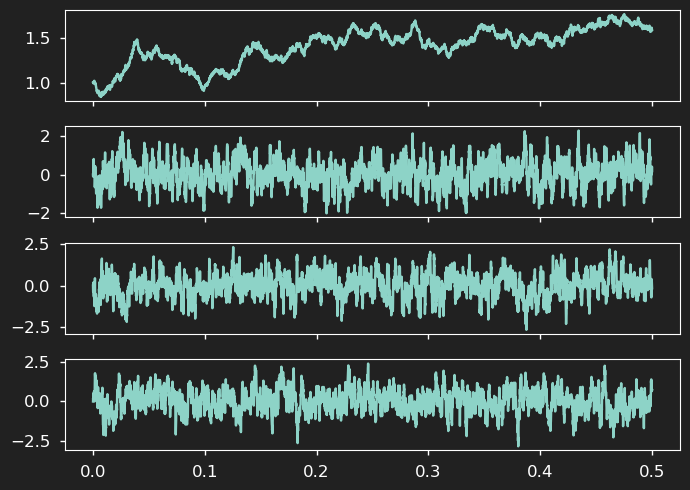

In [133]:
fig, axs = plt.subplots(nrows=len(path.T), sharex=True)
for p, ax in zip(path.T, axs):
    ax.plot(time, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [134]:
data = path[::2]
data.shape

(2501, 4)

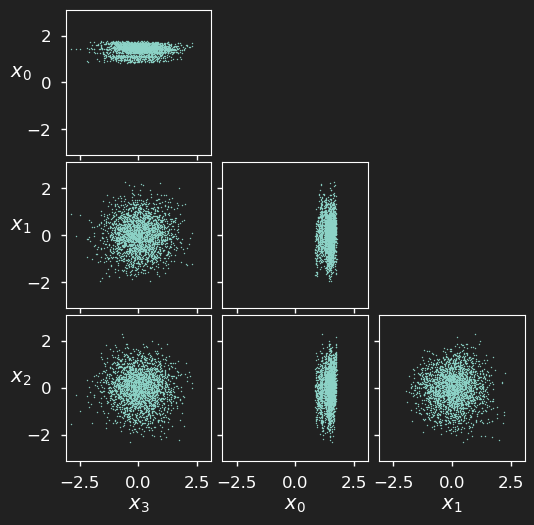

In [135]:
fig = plt.figure(figsize=(2*D,2*D))

gs = mpl_utils.coord_grid(fig, data, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

## Observed process

In [121]:
i, j = np.indices((D, D))

def drif_obs(t, x, dx):
    x1, x2 = x[:Ds], x[Ds:]
    
    dx[:Ds] = ( 1.0 + eps - 2*x2[:Ds]**2 ) / eps
    dx[Ds:] = -x2 / eps

def disp_obs(t, x, dx):
    x1, x2 = x[:Ds], x[Ds:]
    
    dx[(j==i)*(i< Ds)] = 1.0
    dx[(j==i)*(i>=Ds)] = 1.0 / np.sqrt(eps)
    
    dx[(j==i+Ds)*(i<Ds)] = 2*x2[:Ds] / np.sqrt(eps)

sde_obs = spaths.ItoSDE(drif_obs, disp_obs, noise_mixing_dim=D)

In [122]:
# seed setting and solver
seed = 9735
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [123]:
sol_obs = em.solve(sde_obs, ens0, (0,.4), dt/3)
sol_obs.x.shape

(12002, 1, 4)

In [124]:
time_obs = sol_obs.t
path_obs = sol_obs.p[0]

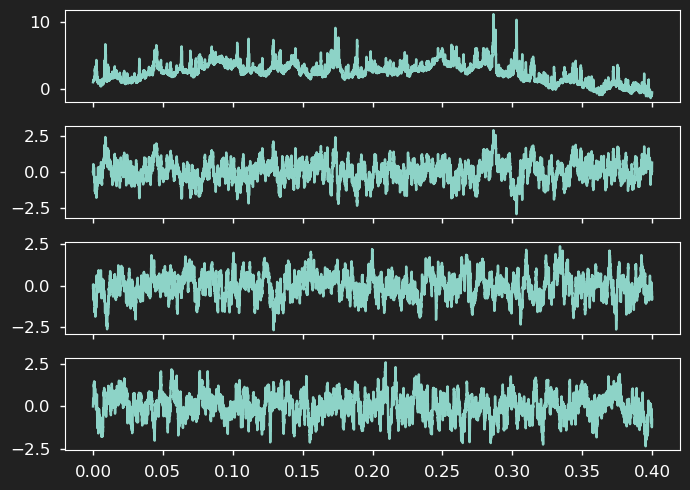

In [125]:
fig, axs = plt.subplots(nrows=len(path_obs.T), sharex=True)
for p, ax in zip(path_obs.T, axs):
    ax.plot(time_obs, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

### Slow map

In [126]:
def slow_map(x):
    x1, x2 = x[:Ds], x[Ds:]
    return x1 - x2[:Ds]**2

In [127]:
y = slow_map(path_obs.T)

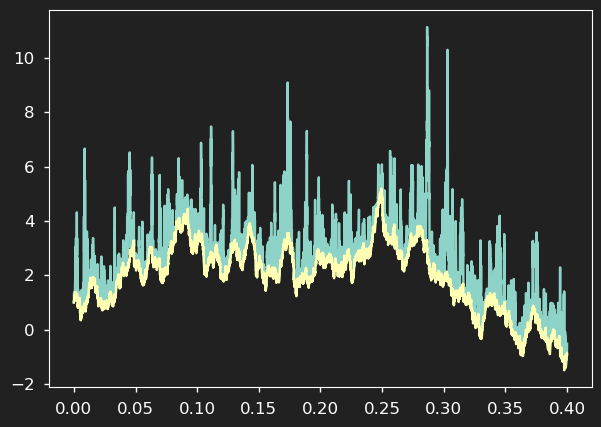

In [128]:
plt.plot(time_obs, path_obs.T[0]);
plt.plot(time_obs, y[0]);

### Dataset

In [19]:
data_obs = path_obs[::4]
data_obs.shape

(3001, 4)

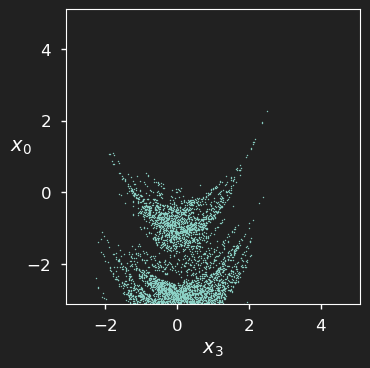

In [136]:
fig = plt.figure(figsize=(2*D,2*D))

gs = mpl_utils.coord_grid(fig, data_obs, xylim=[-3.1, 5.1])

plt.show(fig)
plt.close(fig)

### Projection on slow manifold

In [21]:
def slow_proj(data, sde, nreps, tspan, dt):
    nsam, ndim = data.shape
    ens0 = np.repeat(data, nreps, axis=0)
    nsteps = int(tspan[1]/dt)
    bursts = em.burst(sde, ens0, (0, nsteps), dt).reshape(nsam, nreps, ndim)
    return np.nanmean(bursts, axis=1)

In [22]:
sp = slow_proj(data_obs, sde_obs, 250, (0, 4*eps), dt/2)
sp.shape

(3001, 4)

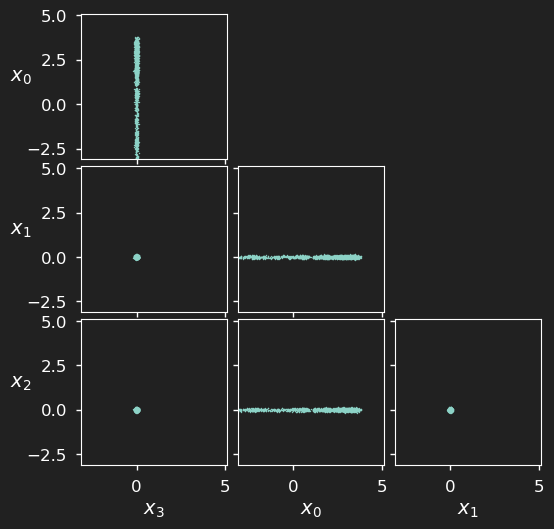

In [23]:
fig = plt.figure(figsize=(2*D,2*D))

gs = mpl_utils.coord_grid(fig, sp, xylim=[-3.1, 5.1])

plt.show(fig)
plt.close(fig)

### 2D version

In [54]:
def drif_obs(t, x, dx):
    
    dx[0] = ( 0.5 + eps - x[1]**2 ) / eps
    dx[1] = -x[1] / eps

def disp_obs(t, x, dx):
    x1, x2 = x[:Ds], x[Ds:]
    
#     dx[0,0] = 1.0 
    dx[1,1] = 1.0 / np.sqrt(eps)
    
    dx[0,1] = x[1] / np.sqrt(eps)

sde_obs = spaths.ItoSDE(drif_obs, disp_obs, noise_mixing_dim=2)

In [55]:
sol_obs = em.solve(sde_obs, [[0.0,0.0]], (0,.5), dt/2)
sol_obs.x.shape

(10002, 1, 2)

In [56]:
time_obs = sol_obs.t
path_obs = sol_obs.p[0]

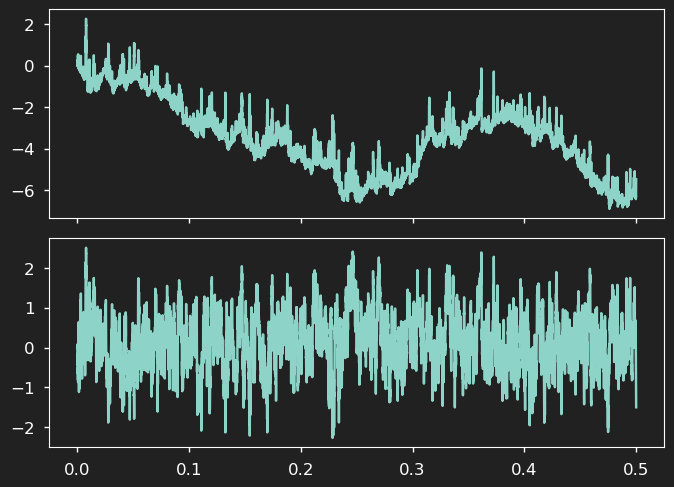

In [57]:
fig, axs = plt.subplots(nrows=len(path_obs.T), sharex=True)
for p, ax in zip(path_obs.T, axs):
    ax.plot(time_obs, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [58]:
data_obs = path_obs
data_obs.shape

(10002, 2)

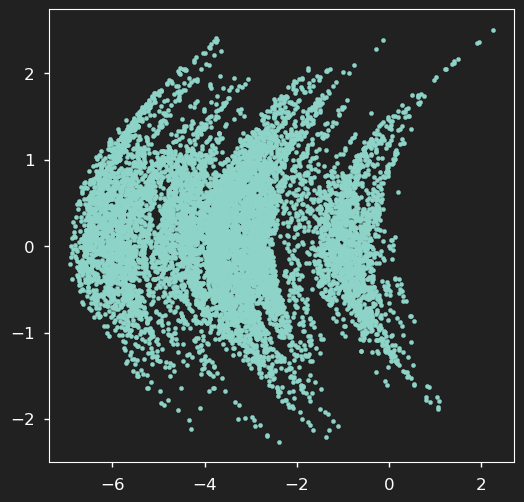

In [59]:
fig = plt.figure(figsize=(6,6))

# gs = mpl_utils.coord_grid(fig, data_obs, xylim=[-1.1, 4.1])
plt.scatter(*data_obs.T)

plt.show(fig)
plt.close(fig)

## Coupled hidden process

In [236]:
Ds = 2
Df = 4
eps = .001

D = Ds + Df
def drif_lin(t, x, dx):
    y, z = x[:Ds], x[Ds:]
    dy, dz = dx[:Ds], dx[Ds:]
    
    dy      = (1.0 - z[:Ds])
    dz[:-1] = (0.5*z[1:] - z[:-1]) / eps
    dz[-1]  = (1.0*y[0] - z[-1]) / eps

def disp_lin(t, x, dx):
    dx.ravel()[::D+1][:Ds] = 0.5
    dx.ravel()[::D+1][Ds:] = 0.5 / np.sqrt(eps)

sde_lin = spaths.ItoSDE(drif_lin, disp_lin, noise_mixing_dim=D)

In [237]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [238]:
# simulation params
dt = eps / 10
x0 = [1.0]*Ds + [0.0]*Df
tspan = (0.0, 5.0)

In [239]:
ens0 = np.array([x0])
sol_lin = em.solve(sde_lin, ens0, tspan, dt)
sol_lin.x.shape

(50001, 1, 6)

In [240]:
time = sol_lin.t
path = sol_lin.p[0]

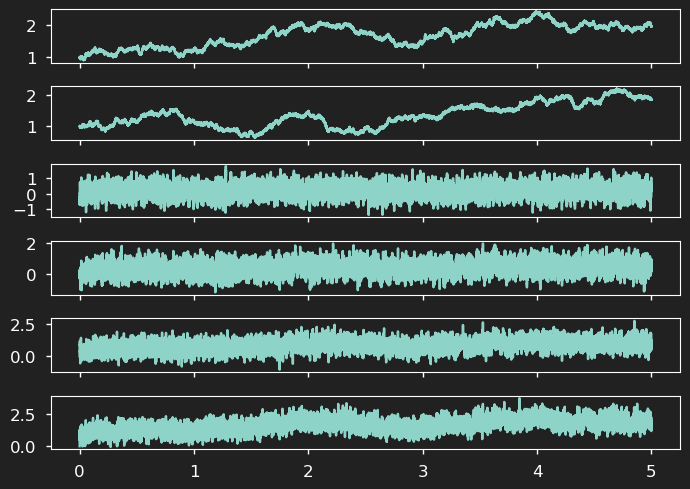

In [241]:
fig, axs = plt.subplots(nrows=len(path.T), sharex=True)
for p, ax in zip(path.T, axs):
    ax.plot(time, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [242]:
data = path[::10]
data.shape

(5001, 6)

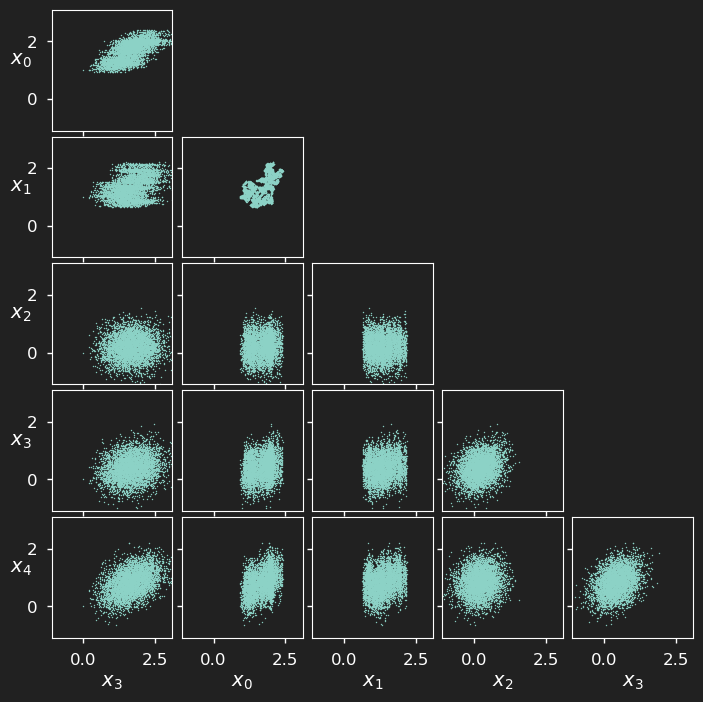

In [243]:
fig = plt.figure(figsize=(10,10))

gs = mpl_utils.coord_grid(fig, data, xylim=[-1.1, 3.1])

plt.show(fig)
plt.close(fig)

In [244]:
def fwdF(x):
    y, z = x[:Ds], x[Ds:]
    return jnp.concatenate([y + z[:Ds]**2, z], axis=0)

def bwdF(x):
    return jnp.concatenate([x[:Ds] - x[Ds:2*Ds]**2, x[Ds:]], axis=0)

F = spaths.SDETransform(fwdF, bwdF)

In [245]:
Fdata = fwdF(data.T).T
Fdata.shape

(5001, 6)

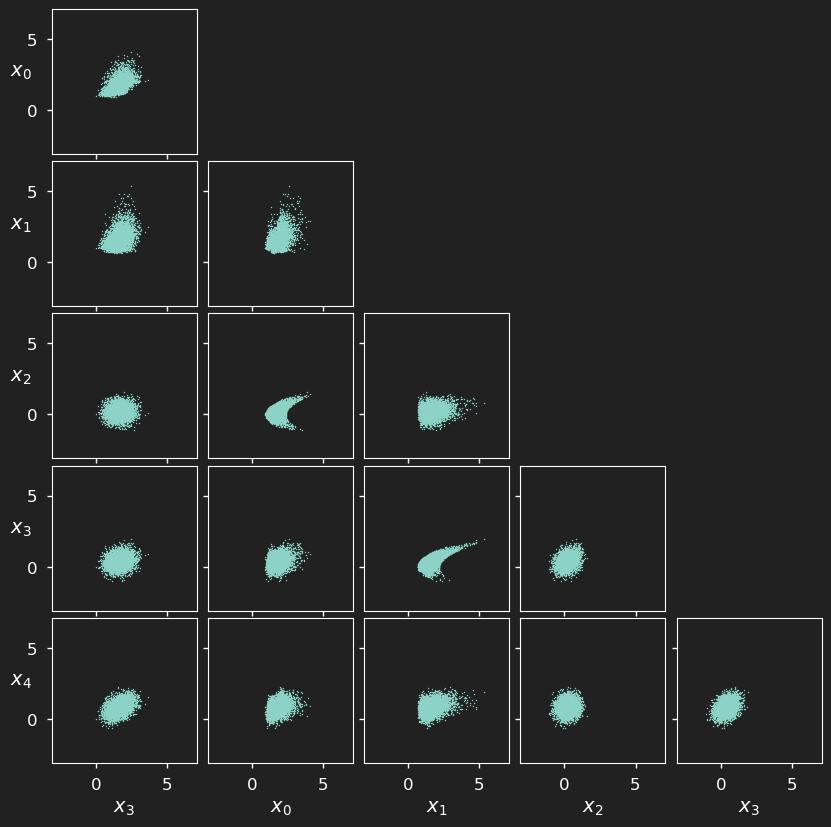

In [246]:
fig = plt.figure(figsize=(12,12))

gs = mpl_utils.coord_grid(fig, Fdata, xylim=[-3.1, 7.1])

plt.show(fig)
plt.close(fig)

In [247]:
Fsde_lin = F(sde_lin)

In [248]:
Fens0 = fwdF(ens0.T).T
Fens0.shape

(1, 6)

In [249]:
# sol_Flin = em.solve(Fsde_lin, Fens0, tspan, dt)
# sol_Flin.x.shape

## Observed process

In [250]:
i, j = np.indices((D, D))
def drif_obs(t, x, dx):
    x1, x2 = x[:Ds], x[Ds:]
    dx1, dx2 = dx[:Ds], dx[Ds:]
    
    dx1      = ( eps + .25 + (x2[1:Ds+1] - 2*x2[:Ds] - eps)*x2[:Ds] ) / eps
    dx2[:-1] = ( 0.5*x2[1:] - x2[:-1]) / eps
    dx2[-1]  = ( x1[0] - x2[0]**2 - x2[-1] ) / eps
    
def disp_obs(t, x, dx):
    x1, x2 = x[:Ds], x[Ds:]
    
    dx[(i==j)*(i< Ds)] = 0.5
    dx[(i==j)*(i>=Ds)] = 0.5 / np.sqrt(eps)
    
    dx[(i==j-Ds)*(i<Ds)] = x2[:Ds] / np.sqrt(eps)
#     breakpoint()

sde_obs = spaths.ItoSDE(drif_obs, disp_obs, noise_mixing_dim=D)

In [270]:
sol_obs = em.solve(sde_obs, Fens0, (0,0.1), dt/3)
sol_obs.x.shape

(3002, 1, 6)

In [271]:
time_obs = sol_obs.t
path_obs = sol_obs.p[0]

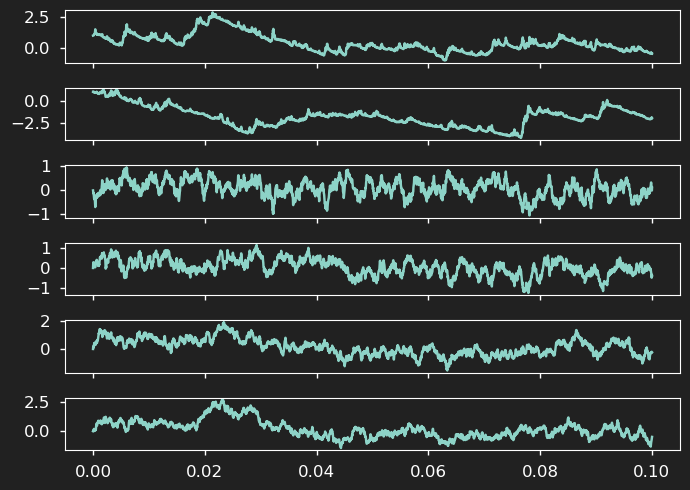

In [272]:
fig, axs = plt.subplots(nrows=len(path_obs.T), sharex=True)
for p, ax in zip(path_obs.T, axs):
    ax.plot(time_obs, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [273]:
data_obs = path_obs
data_obs.shape

(3002, 6)

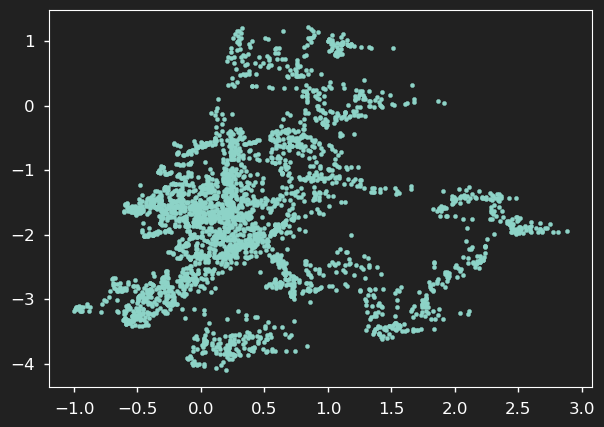

In [274]:
plt.scatter(*data_obs.T[:2])

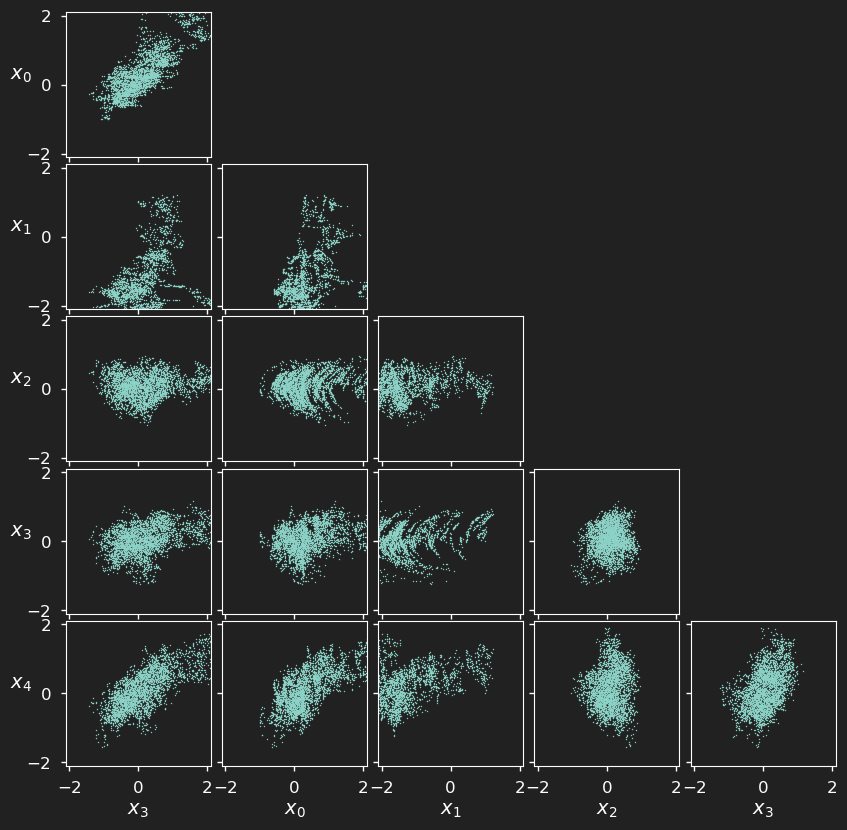

In [277]:
fig = plt.figure(figsize=(12,12))

gs = mpl_utils.coord_grid(fig, data_obs, xylim=[-2.1, 2.1])

plt.show(fig)
plt.close(fig)